<center> <h1> Customer Segmentation in Banking </h1> </center>
<p style="margin-bottom:1cm;"></p>

# Dependencies

In [1]:
%matplotlib inline
%load_ext lab_black

In [2]:
from configparser import ConfigParser
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    f1_score,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from imblearn.under_sampling import RandomUnderSampler

In [3]:
# to use the seaborn style in the matplotlib plots
plt.style.use("seaborn")

## Data understanding

Load the data and have a look at the basic properties.

In [4]:
parser = ConfigParser()
_ = parser.read("notebook.cfg")

path = parser.get("my_api", "path")

In [5]:
data_path = path + "/Data/banking.csv"

In [6]:
df_raw = pd.read_csv(data_path)
df = df_raw.copy()
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [7]:
# Check the type of values of each column
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

In [8]:
# Check the shape of the DataFrame
df.shape

(41188, 21)

In [9]:
# Check if the df has NaN values
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [10]:
# Some information about each feature
df.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


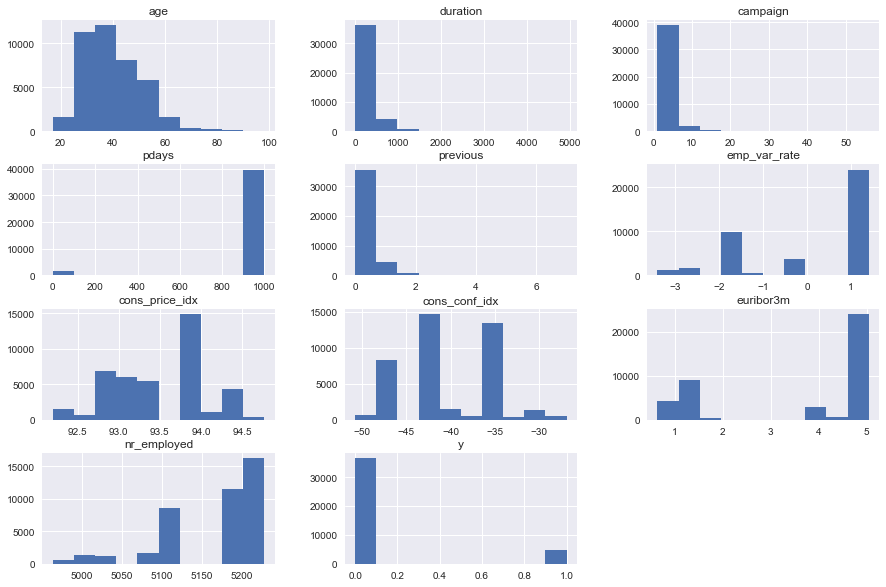

In [11]:
# This creats histograms for all numerical features
df.hist(figsize=(15, 10))
None

In [12]:
# Let's check the number of categories per categorical feature
df.select_dtypes(include=["object"]).apply(lambda col: len(col.unique()))

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

In [13]:
# Take a closer look at features with many categories
print(f"Job categories:\n{df['job'].unique()}\n")
print(f"Month categories:\n{df['month'].unique()}\n")
print(f"Education categories:\n{df['education'].unique()}")

Job categories:
['blue-collar' 'technician' 'management' 'services' 'retired' 'admin.'
 'housemaid' 'unemployed' 'entrepreneur' 'self-employed' 'unknown'
 'student']

Month categories:
['aug' 'nov' 'jun' 'apr' 'jul' 'may' 'oct' 'mar' 'sep' 'dec']

Education categories:
['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']


In general, the categories look pretty clean. For the education categories we can combine the different levels of basic education to reduce the number of categories.

## Data preprocessing

### Feature extraction 

Don't use the feature 'duration' for building a model since the description of this feature states: 

Last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [14]:
# check the name of the columns
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [15]:
# get features and corresponding outcomes
df_clean = df.drop(columns=["duration"])
df_clean

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,0
41184,31,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,2,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0


### Train-Test Split

We separate the dataset into train and test as follows in order to perform sampling later.   
Taking sample from the whole dataset (with 'y' included) is easier than taking it separately from X_train and y_train.  

In [16]:
X = df_clean.iloc[:, :-1]
y = df_clean["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=19
)

### Split numerical and categorical features
For data preprocessing we have to separate numerical and categorical features. Different preprocessing steps are required for both type of features.

In [17]:
categorical_features = df_clean.iloc[:, list(np.where(X.dtypes == "object")[0])].columns
numerical_features = df_clean.iloc[:, list(np.where(X.dtypes != "object")[0])].columns
categorical_features, numerical_features

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'day_of_week', 'poutcome'],
       dtype='object'),
 Index(['age', 'campaign', 'pdays', 'previous', 'emp_var_rate',
        'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
       dtype='object'))

### Scaling and encoding using a scikit-learn pipeline

Here we show how to apply different preprocessing and feature extraction pipelines for the case of dataset that contain heterogeneous data types, since we may want to **scale** the numeric features and **one-hot encode** the categorical ones.

Finally, the preprocessing pipeline is integrated in a full prediction pipeline using sklearn.pipeline.Pipeline, together with the specific ml model.

In [18]:
# The numeric data is standard-scaled
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# while the categorical data is one-hot encoded
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

# The column transformer allows to apply different preprocessing steps for individual sets of columns
# transformers must support fit and transform.
# Special-cased strings ‘drop’ and ‘passthrough’ are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Logistic Regression

Let's compare how Logistic Regression with no penalty, L1 and L2 penalties works

### No penalty 

In [19]:
# We use in this case solver = 'lbfgs' because it works for no penalty Logistic Regression
model_0 = LogisticRegression(
    class_weight="balanced", solver="lbfgs", penalty="none", max_iter=1000
)

#  implement pipeline
pipeline_nopenality = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model_0)]
)

In [20]:
# check the cross validation score
lr_nopenalty_scores_f1 = cross_val_score(
    pipeline_nopenality, X_train, y_train, cv=10, scoring="f1"
)
print(lr_nopenalty_scores_f1)
lr_nopenalty_score_f1 = np.mean(lr_nopenalty_scores_f1)

[0.44654683 0.41737488 0.41803279 0.46047431 0.43592331 0.47884615
 0.44015444 0.46153846 0.44759207 0.46692607]


### L1 Cross-Validation

In [21]:
# We are going to apply different alpha values to the L1 and L2 penalties
# That's why we have to define it firstly
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

score_df_f1 = pd.DataFrame()
score_df_f1["alpha"] = alphas

In [22]:
model_l1 = LogisticRegression(
    class_weight="balanced", penalty="l1", solver="liblinear", max_iter=1000
)
pipeline_l1 = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model_l1)])

In [23]:
scores_l1 = []
for alpha in alphas:
    pipeline_l1.set_params(classifier__C=1 / alpha)
    scores = cross_val_score(pipeline_l1, X_train, y_train, cv=4, scoring="f1")

    print(alpha, "-", scores)
    score = np.mean(scores)

    scores_l1.append(score)

score_df_f1["L1"] = scores_l1

0.0001 - [0.42879499 0.44798725 0.4607806  0.45534017]
0.001 - [0.42896282 0.44798725 0.4607806  0.45534017]
0.01 - [0.42879499 0.44798725 0.46060606 0.45534017]
0.1 - [0.42896282 0.44798725 0.46060606 0.45575389]
1 - [0.4297456  0.44780876 0.46142209 0.45582101]
10 - [0.42829382 0.4429583  0.46038303 0.45677614]
100 - [0.42988414 0.43372549 0.45839753 0.45047081]
1000 - [0.35271944 0.35633139 0.37069922 0.36858006]


### L2 Cross-Validation

In [24]:
model_l2 = LogisticRegression(class_weight="balanced", penalty="l2", solver="liblinear")
pipeline_l2 = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model_l2)])

In [25]:
scores_l2 = []
for alpha in alphas:
    pipeline_l2.set_params(classifier__C=1 / alpha)
    scores = cross_val_score(pipeline_l2, X_train, y_train, cv=4, scoring="f1")

    print(alpha, "-", scores)
    score = np.mean(scores)

    scores_l2.append(score)

score_df_f1["L2"] = scores_l2

0.0001 - [0.42879499 0.44798725 0.4607806  0.45534017]
0.001 - [0.42879499 0.44798725 0.4607806  0.45534017]
0.01 - [0.42879499 0.44798725 0.4607806  0.45534017]
0.1 - [0.42879499 0.44798725 0.46060606 0.45592705]
1 - [0.42924159 0.44780876 0.46089913 0.4549943 ]
10 - [0.42647059 0.44453186 0.45905334 0.45557229]
100 - [0.4183252  0.42976462 0.44897959 0.44638313]
1000 - [0.39216966 0.39130435 0.41289915 0.40689875]


In [26]:
score_df_f1

,alpha,L1,L2
0,0.0001,0.448226,0.448226
1,0.0010,0.448268,0.448226
2,0.0100,0.448182,0.448226
3,0.1000,0.448328,0.448329
4,1.0000,0.448699,0.448236
5,10.0000,0.447103,0.446407
6,100.0000,0.443119,0.435863
7,1000.0000,0.362083,0.400818


In [27]:
score_df_f1.describe()

,alpha,L1,L2
count,8.000000,8.000000,8.000000
mean,138.888888,0.436751,0.440541
std,349.648809,0.030225,0.016610
min,0.000100,0.362083,0.400818
25%,0.007750,0.446107,0.443771
50%,0.550000,0.448204,0.448226
75%,32.500000,0.448283,0.448228
max,1000.000000,0.448699,0.448329


Select the best model by comparing 'f1' score.
You can also try different scoring parameter

In [28]:
score_df_f1["L1"]

0    0.448226
1    0.448268
2    0.448182
3    0.448328
4    0.448699
5    0.447103
6    0.443119
7    0.362083
Name: L1, dtype: float64

In [29]:
lr_nopenalty_score_f1

0.4473409311157277

Text(0, 0.5, 'f1 score')

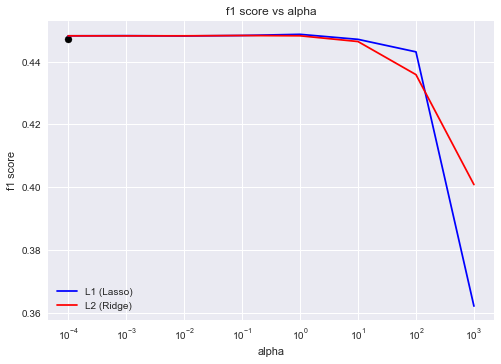

In [30]:
# Lasso
plt.semilogx(score_df_f1["alpha"], score_df_f1["L1"], color="blue", label="L1 (Lasso)")

# Ridge
plt.semilogx(score_df_f1["alpha"], score_df_f1["L2"], color="red", label="L2 (Ridge)")
plt.scatter(x=alphas[0], y=lr_nopenalty_score_f1, color="black")
plt.title("f1 score vs alpha")
plt.xlabel("alpha")
plt.legend()
plt.ylabel("f1 score")

Let's find out the maximum score and the best penalty

In [31]:
score_df_f1.L1.max(), score_df_f1.L2.max(), lr_nopenalty_score_f1

(0.44869936456924897, 0.44832883759194353, 0.4473409311157277)

Another way to check for the best score

In [32]:
score_df_f1.iloc[[score_df_f1.drop(columns=["alpha"]).stack().idxmax()[0]]]

,alpha,L1,L2
4,1.0,0.448699,0.448236


In [33]:
best_alpha = score_df_f1.iloc[
    [score_df_f1.drop(columns=["alpha"]).stack().idxmax()[0]]
].alpha.values[0]
best_penalty = [score_df_f1.drop(columns=["alpha"]).stack().idxmax()][0][1]
print("The best alpha and penalty are {} and {}".format(best_alpha, best_penalty))

The best alpha and penalty are 1.0 and L1


### Modeling with the best selected model (Logisic Regression)

In [34]:
pipeline_best_model = pipeline_l1.set_params(
    classifier__C=1 / best_alpha, classifier__penalty=best_penalty.lower()
)

# fit and view model parameters
pipeline_best_model.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', m

Predictions with the best model

In [35]:
predictions_train = pipeline_best_model.predict_proba(X_train)[:, 1]
predictions_test = pipeline_best_model.predict_proba(X_test)[:, 1]
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, predictions_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, predictions_test)

In [36]:
scores = []

pred_lr = pipeline_best_model.predict(X_test)
scores.append(f1_score(y_test, pred_lr))

### Plotting

A ROC curve is considered to be good if it is closer to the top left corner, and the straight line connecting (0,0) and (1,1) represents a random classier with even odds.

The advantage of using ROC is that one can visually see for what region a model is more superior compare to another.

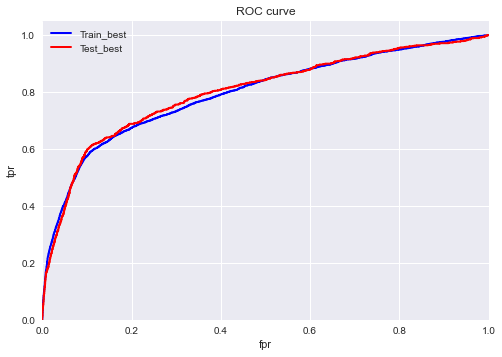

In [37]:
plt.plot(fpr_train, tpr_train, "b", linewidth=2, markersize=4, label="Train_best")
plt.plot(fpr_test, tpr_test, "r", linewidth=2, markersize=4, label="Test_best")

plt.xlabel("fpr")
plt.legend()
plt.ylabel("tpr")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("ROC curve")
None

## KNN

In [38]:
knn = KNeighborsClassifier()
knn

KNeighborsClassifier()

In [39]:
pipeline_knn = Pipeline([("col_transformer", preprocessor), ("estimator", knn)])

In [40]:
pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object'))])),
                ('estimator', KNeighborsClassifier())])

In [41]:
pred_knn = pipeline_knn.predict(X_test)
scores.append(f1_score(y_test, pred_knn))

In [42]:
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7292
           1       0.51      0.25      0.34       946

    accuracy                           0.89      8238
   macro avg       0.71      0.61      0.64      8238
weighted avg       0.86      0.89      0.87      8238



## Naive Bayes

In [43]:
nb = BernoulliNB()

pipeline_nb = Pipeline([("col_transformer", preprocessor), ("estimator", nb)])

In [44]:
pipeline_nb.fit(X_train, y_train)

pred_nb = pipeline_nb.predict(X_test)
scores.append(f1_score(y_test, pred_nb))

In [45]:
print(classification_report(y_test, pred_nb))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      7292
           1       0.31      0.62      0.42       946

    accuracy                           0.80      8238
   macro avg       0.63      0.72      0.65      8238
weighted avg       0.87      0.80      0.83      8238



## SVM

In [46]:
svm = LinearSVC()

pipeline_svm = Pipeline([("col_transformer", preprocessor), ("estimator", svm)])

In [47]:
pipeline_svm.fit(X_train, y_train)

pred_svm = pipeline_svm.predict(X_test)
scores.append(f1_score(y_test, pred_svm))

C:\Users\juana_0mrk5mk\anaconda3\envs\MLG\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [48]:
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7292
           1       0.64      0.19      0.29       946

    accuracy                           0.89      8238
   macro avg       0.77      0.59      0.62      8238
weighted avg       0.87      0.89      0.87      8238



## RandomForestClassifier

In [49]:
rfc = RandomForestClassifier(n_estimators=500, random_state=42)

pipeline_rfc = Pipeline([("col_transformer", preprocessor), ("estimator", rfc)])

In [50]:
pipeline_rfc.fit(X_train, y_train)

pred_rfc = pipeline_rfc.predict(X_test)
scores.append(f1_score(y_test, pred_rfc))

In [51]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7292
           1       0.55      0.27      0.36       946

    accuracy                           0.89      8238
   macro avg       0.73      0.62      0.65      8238
weighted avg       0.87      0.89      0.87      8238



## AdaBoost

In [52]:
ada = AdaBoostClassifier()

pipeline_ada = Pipeline([("col_transformer", preprocessor), ("estimator", ada)])

In [53]:
pipeline_ada.fit(X_train, y_train)

pred_ada = pipeline_ada.predict(X_test)
scores.append(f1_score(y_test, pred_ada))

In [54]:
print(classification_report(y_test, pred_ada))

              precision    recall  f1-score   support

           0       0.91      0.99      0.94      7292
           1       0.67      0.20      0.31       946

    accuracy                           0.90      8238
   macro avg       0.79      0.60      0.63      8238
weighted avg       0.88      0.90      0.87      8238



In [55]:
ada2 = AdaBoostClassifier(
    n_estimators=100,
    base_estimator=DecisionTreeClassifier(max_depth=8, random_state=42),
    random_state=42,
)
pipeline_ada2 = Pipeline([("col_transformer", preprocessor), ("estimator", ada2)])
pipeline_ada2.fit(X_train, y_train)
pred_ada = pipeline_ada2.predict(X_test)
print(classification_report(y_test, pred_ada))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      7292
           1       0.41      0.28      0.33       946

    accuracy                           0.87      8238
   macro avg       0.66      0.62      0.63      8238
weighted avg       0.85      0.87      0.86      8238



## XGBoost

In [56]:
xgb = XGBClassifier()

pipeline_xgb = Pipeline([("col_transformer", preprocessor), ("estimator", xgb)])

In [57]:
pipeline_xgb.fit(X_train, y_train)

pred_xgb = pipeline_xgb.predict(X_test)
scores.append(f1_score(y_test, pred_xgb))

C:\Users\juana_0mrk5mk\anaconda3\envs\MLG\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:12:04] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [58]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7292
           1       0.59      0.27      0.37       946

    accuracy                           0.89      8238
   macro avg       0.75      0.62      0.66      8238
weighted avg       0.87      0.89      0.88      8238



### Compare model performance

<BarContainer object of 7 artists>

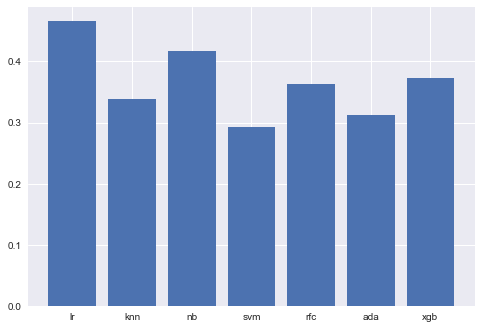

In [59]:
models = ["lr", "knn", "nb", "svm", "rfc", "ada", "xgb"]
plt.bar(models, scores)

In [60]:
models

['lr', 'knn', 'nb', 'svm', 'rfc', 'ada', 'xgb']

In [61]:
scores

[0.46615384615384614,
 0.3382873319179051,
 0.4172303310786757,
 0.2922448979591837,
 0.3635077793493635,
 0.3130575831305758,
 0.3721940622737147]

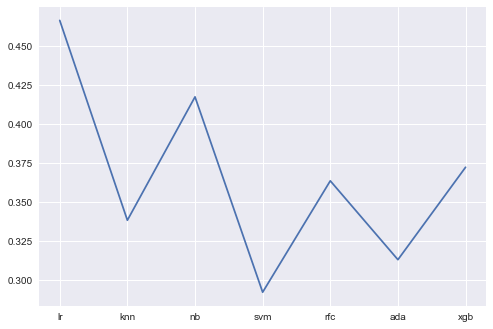

In [62]:
plt.plot(models, scores)

### Feature Importance 

Trees based models like RandomForest, XGBoost, etc.  provide us feature importance based on the training.

In [63]:
pipeline_rfc

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object'))])),
                ('estimator',
                 RandomForestClassifier(n_estimators=500, ra

In [64]:
rfc_model = pipeline_rfc["estimator"]
rfc_model

RandomForestClassifier(n_estimators=500, random_state=42)

In [65]:
pipeline_rfc["col_transformer"].transformers_

[('num',
  Pipeline(steps=[('scaler', StandardScaler())]),
  Index(['age', 'campaign', 'pdays', 'previous', 'emp_var_rate',
         'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
        dtype='object')),
 ('cat',
  Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]),
  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
         'month', 'day_of_week', 'poutcome'],
        dtype='object'))]

In [66]:
num_feat = list(pipeline_rfc["col_transformer"].transformers_[0][2])
cat_feat = list(
    pipeline_rfc["col_transformer"]
    .transformers_[1][1]["onehot"]
    .get_feature_names(categorical_features)
)

In [67]:
feature_columns = num_feat + cat_feat
feature_columns

['age',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_basic.4y',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_no',
 'default_unknown',
 'default_yes',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_fri',
 'day_of_week_mon',

In [68]:
rfc_model.feature_importances_

array([1.57696990e-01, 8.19494073e-02, 3.45615874e-02, 1.39044873e-02,
       2.29044890e-02, 2.28864373e-02, 2.55208972e-02, 1.17432030e-01,
       5.04528270e-02, 1.75164447e-02, 1.20323342e-02, 5.61588916e-03,
       4.55408586e-03, 9.25707176e-03, 7.01928663e-03, 6.08278011e-03,
       9.24059593e-03, 5.39168170e-03, 1.43452660e-02, 5.22923319e-03,
       2.36131747e-03, 1.04573627e-02, 1.66310109e-02, 1.46827765e-02,
       6.03572490e-04, 8.33623827e-03, 6.89253127e-03, 1.14436477e-02,
       1.64077866e-02, 3.94660170e-04, 1.18151431e-02, 1.59971740e-02,
       6.82308311e-03, 8.07628867e-03, 8.10072405e-03, 1.28207209e-06,
       2.10315037e-02, 2.52784148e-03, 2.08941791e-02, 1.38178775e-02,
       2.51539921e-03, 1.33707084e-02, 7.91070487e-03, 7.73129576e-03,
       3.29209845e-03, 2.67042210e-03, 1.04967052e-03, 2.72254446e-03,
       2.83970409e-03, 4.59391222e-03, 4.69675304e-03, 2.41003883e-03,
       5.11314903e-03, 2.72240471e-03, 1.38543901e-02, 1.55294266e-02,
      

In [69]:
rfc_importances = pd.DataFrame(
    {"feature": feature_columns, "importance": np.round(rfc.feature_importances_, 3)}
)
rfc_importances = rfc_importances.sort_values("importance", ascending=False).set_index(
    "feature"
)
rfc_importances

,importance
feature,
age,0.158
euribor3m,0.117
campaign,0.082
nr_employed,0.050
pdays,0.035
...,...
job_unknown,0.002
month_dec,0.001
marital_unknown,0.001


In [87]:
# rfc_importances
rfc_importances.index

Index(['age', 'euribor3m', 'campaign', 'nr_employed', 'pdays', 'cons_conf_idx',
       'poutcome_success', 'cons_price_idx', 'emp_var_rate', 'housing_yes',
       'housing_no', 'job_admin.', 'marital_married', 'day_of_week_mon',
       'education_high.school', 'education_university.degree',
       'day_of_week_wed', 'day_of_week_tue', 'day_of_week_thu',
       'marital_single', 'loan_no', 'job_technician', 'day_of_week_fri',
       'previous', 'loan_yes', 'education_professional.course',
       'job_blue-collar', 'education_basic.9y', 'marital_divorced',
       'job_management', 'job_services', 'default_unknown', 'contact_cellular',
       'education_basic.4y', 'contact_telephone', 'poutcome_failure',
       'poutcome_nonexistent', 'default_no', 'education_basic.6y',
       'job_retired', 'education_unknown', 'job_self-employed',
       'job_entrepreneur', 'job_housemaid', 'job_student', 'month_may',
       'job_unemployed', 'month_oct', 'month_mar', 'month_sep', 'month_apr',
       'm

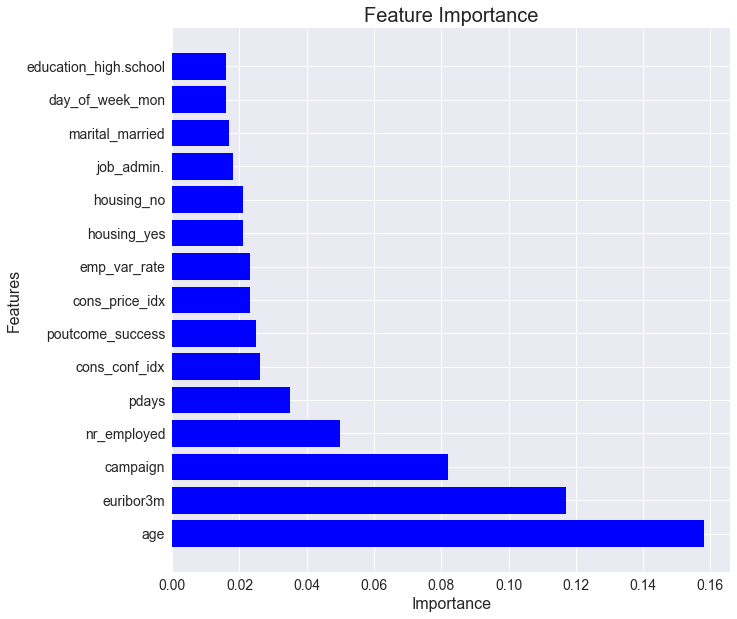

In [121]:
# update the overall font size
plt.rcParams.update({"font.size": 5})

f, ax = plt.subplots(figsize=(10, 10))
plt.rcParams["font.size"] = "16"
ax.barh(rfc_importances.index[:15], rfc_importances["importance"][:15], color="blue")
ax.set_title("Feature Importance", fontsize=20)
ax.set_xlabel("Importance", fontsize=16)
# ax.set_xticklabels(rfc_importances["importance"][:15])
ax.set_ylabel("Features", fontsize=16)
# ax.set_xticks()

ax.tick_params(labelsize=14)

plt.savefig("images/feature_importance.jpg", bbox_inches="tight")
plt.show()